### Isotonic Regression

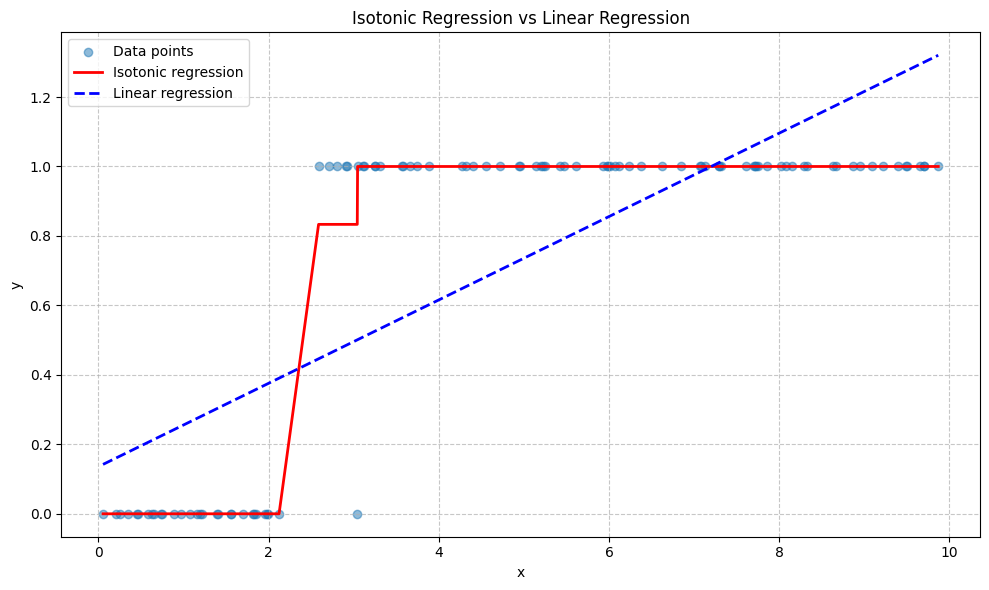

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# Generate synthetic data with a non-linear, generally increasing trend
np.random.seed(42)
x = np.sort(np.random.rand(100) * 10)
# Underlying function is non-linear: y = x^0.5 + noise
y_true = np.sqrt(x)
y = (y_true + np.random.normal(0, 0.3, size=len(x)) > 1.5).astype(int)

# Fit isotonic regression
ir = IsotonicRegression()
y_isotonic = ir.fit_transform(x, y)

# Fit linear regression for comparison
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)
y_linear = lr.predict(x.reshape(-1, 1))

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Data points')
plt.plot(x, y_isotonic, 'r-', label='Isotonic regression', linewidth=2)
plt.plot(x, y_linear, 'b--', label='Linear regression', linewidth=2)
plt.legend(loc='upper left')
plt.title('Isotonic Regression vs Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Import Data


In [2]:
import numpy as np
import pandas as pd
import altair as alt
from jinja2 import Template


from utils import SandEDA

df = pd.read_csv("./database/Playground_Churn_Bank.csv")

del df['id']

# Define the specific dates range
start_date = "2023-06-01"
end_date = "2023-09-30"

safra = []
# Generate a random date within the specified range
for i in range(df.shape[0]):
    safra.append(
        pd.to_datetime(
            np.random.choice(pd.date_range(start=start_date, end=end_date))
        ).strftime("%Y%m")
    )

df["safra"] = safra

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Select columns based on df types
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])


### Models testing

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Define the features and target
X = df.drop(columns=['Exited', 'CustomerId', 'safra'])
y = df['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=2000)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

Decision Tree Accuracy: 0.7965, ROC AUC: 0.7063
Random Forest Accuracy: 0.8607, ROC AUC: 0.8799
XGBoost Accuracy: 0.8672, ROC AUC: 0.8914
Logistic Regression Accuracy: 0.8275, ROC AUC: 0.8038


/home/lucas/Projects/janestreet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
df['PROB_CHURN'] = classifiers.get('XGBoost').predict_proba(df.drop(columns=['Exited', 'CustomerId', 'safra']))[:,1]

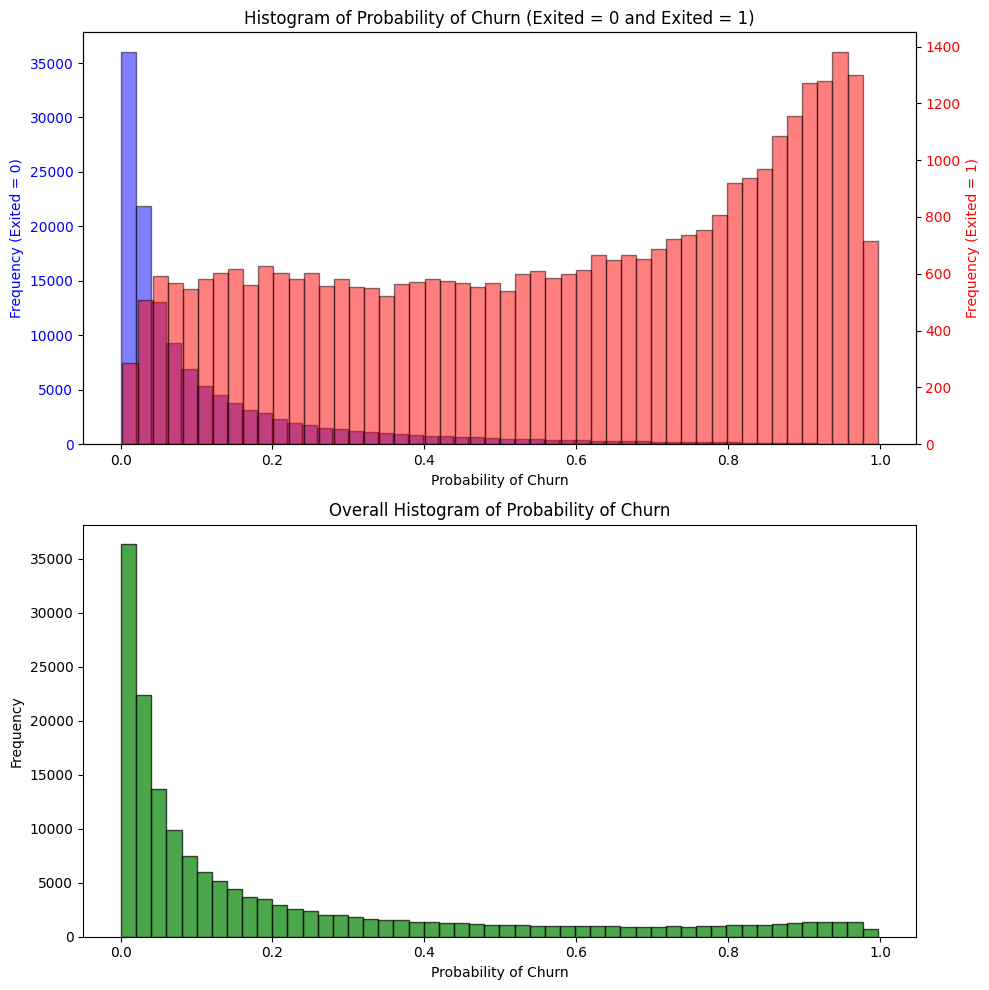

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the histogram for PROB_CHURN when Exited = 0
ax1.hist(df[df['Exited'] == 0]['PROB_CHURN'], bins=50, edgecolor='black', alpha=0.5, color='blue', label='Exited = 0')
ax1.set_xlabel('Probability of Churn')
ax1.set_ylabel('Frequency (Exited = 0)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
# Plot the histogram for PROB_CHURN when Exited = 1
ax2.hist(df[df['Exited'] == 1]['PROB_CHURN'], bins=50, edgecolor='black', alpha=0.5, color='red', label='Exited = 1')
ax2.set_ylabel('Frequency (Exited = 1)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Histogram of Probability of Churn (Exited = 0 and Exited = 1)')

# Plot the overall histogram for PROB_CHURN
ax3.hist(df['PROB_CHURN'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Probability of Churn')
ax3.set_ylabel('Frequency')
ax3.set_title('Overall Histogram of Probability of Churn')

fig.tight_layout()
plt.show()

### Regressor

In [7]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,safra,PROB_CHURN
0,15674932,1924,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,3,0.015720
1,15749177,1925,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,0.005177
2,15694510,1178,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0.030805
3,15741417,1299,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3,0.032517
4,15766172,467,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0.009885


In [8]:
df_temp = df.drop(columns=['Exited', 'CustomerId', 'safra']).loc[X_train.index]

model = XGBRegressor(eval_metric='logloss')

model.fit(df_temp.loc[X_train.index], df['Exited'].loc[y_train.index], base_margin=df_temp['PROB_CHURN'])
df['REGR'] = model.predict(df.drop(columns=['Exited', 'CustomerId', 'safra']))

df['PROB_CHURN_REGR'] = df['PROB_CHURN'] + df['REGR']

df_temp = df.loc[y_test.index]
y_test = df_temp['Exited']

y_pred = (df_temp['PROB_CHURN_REGR'] > 0.5).astype(int)
y_pred_proba = df_temp['PROB_CHURN_REGR']

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"XGBRegressor Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

XGBRegressor Accuracy: 0.8344, ROC AUC: 0.8709


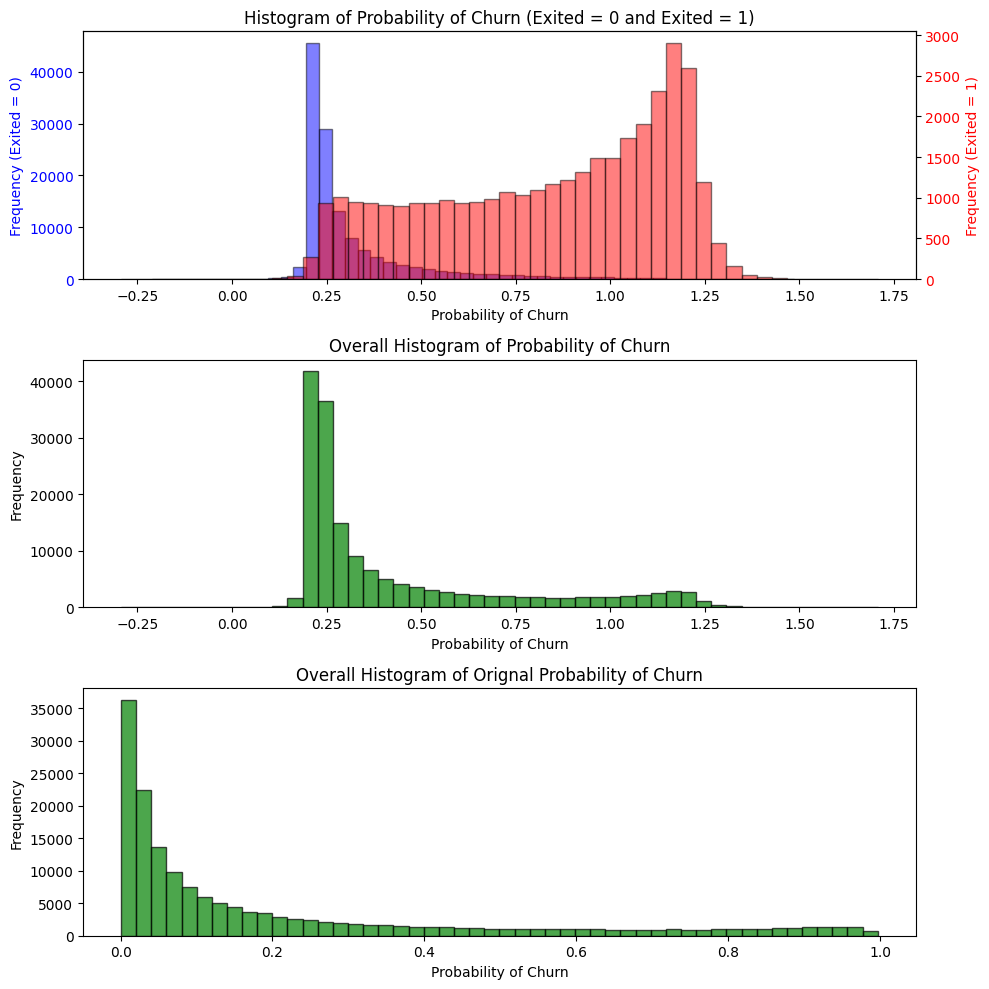

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax3, ax4) = plt.subplots(3, 1, figsize=(10, 10))

# Plot the histogram for PROB_CHURN when Exited = 0
ax1.hist(df[df['Exited'] == 0]['PROB_CHURN_REGR'], bins=50, edgecolor='black', alpha=0.5, color='blue', label='Exited = 0')
ax1.set_xlabel('Probability of Churn')
ax1.set_ylabel('Frequency (Exited = 0)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
# Plot the histogram for PROB_CHURN when Exited = 1
ax2.hist(df[df['Exited'] == 1]['PROB_CHURN_REGR'], bins=50, edgecolor='black', alpha=0.5, color='red', label='Exited = 1')
ax2.set_ylabel('Frequency (Exited = 1)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Histogram of Probability of Churn (Exited = 0 and Exited = 1)')

# Plot the overall histogram for PROB_CHURN
ax3.hist(df['PROB_CHURN_REGR'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Probability of Churn')
ax3.set_ylabel('Frequency')
ax3.set_title('Overall Histogram of Probability of Churn')

# Plot the overall histogram for PROB_CHURN
ax4.hist(df['PROB_CHURN'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax4.set_xlabel('Probability of Churn')
ax4.set_ylabel('Frequency')
ax4.set_title('Overall Histogram of Orignal Probability of Churn')

fig.tight_layout()
plt.show()

### Create GH

In [10]:
# Define the bins and labels for the rating
bins = pd.qcut(df['PROB_CHURN'], q=4, duplicates='drop', retbins=True)[1]
labels = ['TG', 'TG_EX', 'NT_EX', 'NT']

# Create the rating column based on the PROB_CHURN score
df['RTG_CHURN'] = pd.cut(df['PROB_CHURN'], bins=bins, labels=labels)

# Define the bins and labels for the rating
bins = pd.qcut(df['PROB_CHURN_REGR'], q=10, duplicates='drop', retbins=True)[1]
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Create the rating column based on the PROB_CHURN score
df['RTG_CHURN_REGR'] = pd.cut(df['PROB_CHURN_REGR'], bins=bins, labels=labels)

### Report numbers

#### GH Bad Rates

In [11]:
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

# Calculate the average and volume values for RTG_CHURN_REGR
avg_volume_regr = df.groupby('RTG_CHURN_REGR')['Exited'].agg(['mean', 'count']).reset_index()
avg_volume_regr.columns = ['RTG_CHURN_REGR', 'Average_Exited', 'Volume']

# Calculate the average and volume values for RTG_CHURN
avg_volume = df.groupby('RTG_CHURN')['Exited'].agg(['mean', 'count']).reset_index()
avg_volume.columns = ['RTG_CHURN', 'Average_Exited', 'Volume']

# Display the dataframes with enhanced visuals

print("Average and Volume for RTG_CHURN_REGR:")
display(avg_volume_regr.style.background_gradient(cmap='viridis'))

print("\nAverage and Volume for RTG_CHURN:")
display(avg_volume.style.background_gradient(cmap='viridis'))

Average and Volume for RTG_CHURN_REGR:


/tmp/ipykernel_7682/513824499.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_volume_regr = df.groupby('RTG_CHURN_REGR')['Exited'].agg(['mean', 'count']).reset_index()
/tmp/ipykernel_7682/513824499.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_volume = df.groupby('RTG_CHURN')['Exited'].agg(['mean', 'count']).reset_index()


,RTG_CHURN_REGR,Average_Exited,Volume
0,A,0.008665,16503
1,B,0.005635,16503
2,C,0.010422,16503
3,D,0.021207,16504
4,E,0.038054,16503
5,F,0.075380,16503
6,G,0.140390,16504
7,H,0.289341,16503
8,I,0.602921,16503
9,J,0.923897,16504



Average and Volume for RTG_CHURN:


,RTG_CHURN,Average_Exited,Volume
0,TG,0.007611,41258
1,TG_EX,0.038732,41258
2,NT_EX,0.152504,41258
3,NT,0.647544,41259


#### Crossed matrix and swaps

In [12]:
# Pivot table for Volume
volume_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='count', fill_value=0)

# Pivot table for Average Exited
average_exited_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='mean', fill_value=0)

print("Volume Table:")
display(volume_pivot.style.background_gradient(cmap='viridis'))

print("\nAverage Exited Table:")
display(average_exited_pivot.style.background_gradient(cmap='viridis'))

# Calculate the sum over volume_pivot if RTG_CHURN in TG or TG_EX and average_exited value > 0.1
swap_out = volume_pivot.loc[:, ['TG', 'TG_EX']].where(average_exited_pivot > 0.1).sum().sum()
swap_in = volume_pivot.loc[:, ['NT', 'NT_EX']].where(average_exited_pivot < 0.1).sum().sum()
out_out = volume_pivot.loc[:, ['NT', 'NT_EX']].where(average_exited_pivot > 0.1).sum().sum()
in_in = volume_pivot.loc[:, ['TG', 'TG_EX']].where(average_exited_pivot < 0.1).sum().sum()

# Calculate the average from the values of exited = 1, for each metric

sum_exited_swap_out = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['TG', 'TG_EX']].where(average_exited_pivot > 0.1).sum().sum()
sum_exited_swap_in = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['NT', 'NT_EX']].where(average_exited_pivot < 0.1).sum().sum()
sum_exited_out_out = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['NT', 'NT_EX']].where(average_exited_pivot > 0.1).sum().sum()
sum_exited_in_in = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['TG', 'TG_EX']].where(average_exited_pivot < 0.1).sum().sum()

avg_swap_out = sum_exited_swap_out / swap_out
avg_swap_in = sum_exited_swap_in / swap_in
avg_out_out = sum_exited_out_out / out_out
avg_in_in = sum_exited_in_in / in_in

# Create a table with the output values and average exited
output_values = pd.DataFrame({
    'Metric': ['swap_out', 'swap_in', 'out_out', 'in_in'],
    'Value': [swap_out, swap_in, out_out, in_in],
    'Average_Exited': [avg_swap_out, avg_swap_in, avg_out_out, avg_in_in]
})

# Calculate the percentage of the total
total_volume = volume_pivot.sum().sum()
output_values['Percentage'] = (output_values['Value'] / total_volume) * 100

# Display the output values with percentage and average exited
print(output_values)


Volume Table:


/tmp/ipykernel_7682/914542941.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  volume_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='count', fill_value=0)
/tmp/ipykernel_7682/914542941.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  average_exited_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='mean', fill_value=0)


RTG_CHURN,TG,TG_EX,NT_EX,NT
RTG_CHURN_REGR,,,,
A,11145,3708,1500,150
B,14226,1938,324,14
C,11288,4683,517,15
D,4041,11171,1259,33
E,470,12634,3339,60
F,83,6460,9762,198
G,4,631,14863,1006
H,1,31,8804,7667
I,0,2,867,15634



Average Exited Table:


RTG_CHURN,TG,TG_EX,NT_EX,NT
RTG_CHURN_REGR,,,,
A,0.003320,0.012675,0.034667,0.046667
B,0.004499,0.010836,0.024691,0.000000
C,0.008327,0.012812,0.034816,0.000000
D,0.021529,0.019515,0.033360,0.090909
E,0.042553,0.038388,0.035340,0.083333
F,0.120482,0.089474,0.065458,0.085859
G,0.250000,0.261490,0.137119,0.112326
H,1.000000,0.709677,0.313607,0.259684
I,0.000000,1.000000,0.686275,0.598247


     Metric    Value  Average_Exited  Percentage
0  swap_out    752.0        0.267287    0.455669
1   swap_in  17171.0        0.052938   10.404649
2   out_out  65345.0        0.491224   39.595351
3     in_in  81764.0        0.020926   49.544331


/tmp/ipykernel_7682/914542941.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sum_exited_swap_out = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['TG', 'TG_EX']].where(average_exited_pivot > 0.1).sum().sum()
/tmp/ipykernel_7682/914542941.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sum_exited_swap_in = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['NT', 'NT_EX']].where(average_exited_pivot < 0.1).sum().sum()
/tmp/ipykernel_7682/914542941.py:23: FutureWarning: The default value of 

#### Production and final bad estimated

In [13]:
production = swap_in - swap_out
print(f"Production: {production}")

# Calculate production swap_in and swap_out in percentage of total
production_percentage = (production / (total_volume - out_out)) * 100
print(f"Production in percentage of total: {production_percentage:.2f}%")

# Calculate the average from the values of exited = 1, for each metric
num_exited = sum_exited_swap_in + sum_exited_in_in + sum_exited_swap_out

den_exited = swap_in + in_in + swap_out

average_exited = num_exited / den_exited
print(f"Average exited before: {average_exited}")

# Calculate the average from the values of exited = 1, for each metric
num_exited = sum_exited_swap_in + sum_exited_in_in

den_exited = swap_in + in_in

average_exited = num_exited / den_exited
print(f"Average exited after: {average_exited}")

Production: 16419.0
Production in percentage of total: 16.47%
Average exited before: 0.028298574538304894
Average exited after: 0.026482033658462627


### Create report

In [14]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,safra,PROB_CHURN,REGR,PROB_CHURN_REGR,RTG_CHURN,RTG_CHURN_REGR
0,15674932,1924,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,3,0.015720,0.201526,0.217246,TG,B
1,15749177,1925,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,0.005177,0.215049,0.220227,TG,B
2,15694510,1178,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0.030805,0.211861,0.242666,TG_EX,D
3,15741417,1299,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3,0.032517,0.211127,0.243644,TG_EX,D
4,15766172,467,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0.009885,0.206056,0.215941,TG,B


In [35]:
import altair as alt

# Calculate the volume and average exited each month
monthly_stats = df.groupby('safra').agg({'CustomerId': 'count', 'Exited': 'mean'}).reset_index()
monthly_stats.columns = ['safra', 'Volume', 'Average_Exited']

# Create the bar chart for volume
bar_chart = alt.Chart(monthly_stats).mark_bar().encode(
    x='safra:O',
    y='Volume:Q',
    tooltip=['safra', 'Volume']
).properties(width=400, height=200)

# Create the line chart for average exited
line_chart = alt.Chart(monthly_stats).mark_line(color='red').encode(
    x='safra:O',
    y='Average_Exited:Q',
    tooltip=['safra', 'Average_Exited']
).properties(
    width=400, height=200)

combined_chart = alt.layer(bar_chart, line_chart).resolve_scale(
    y='independent'
).properties(
    title='Monthly Volume and Average Exited'
)

# Display the chart
combined_chart.display()

combined_chart_json = combined_chart.to_json()

alt.LayerChart(...)

In [37]:
from sklearn.metrics import roc_auc_score
import altair as alt

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Calculate Gini coefficients
gini_prob_churn = gini(df['Exited'], df['PROB_CHURN'])
gini_regr = gini(df['Exited'], df['REGR'])
gini_prob_churn_regr = gini(df['Exited'], df['PROB_CHURN_REGR'])

print(f"Gini for PROB_CHURN: {gini_prob_churn:.4f}")
print(f"Gini for REGR: {gini_regr:.4f}")
print(f"Gini for PROB_CHURN_REGR: {gini_prob_churn_regr:.4f}")

# Create a DataFrame for the Gini coefficients
gini_data = pd.DataFrame({
    'Model': ['PROB_CHURN', 'REGR', 'PROB_CHURN_REGR'],
    'Gini': [gini_prob_churn, gini_regr, gini_prob_churn_regr]
})

# Create a horizontal bar chart
horizontal_bar_chart = alt.Chart(gini_data).mark_bar().encode(
    x='Gini:Q',
    y=alt.Y('Model:N', sort='-x'),
    tooltip=['Model', 'Gini']
).properties(
    title='Gini Coefficients per Model',
    width=200,
    height=200
)

# Display the chart
horizontal_bar_chart.display()
gini_bar_chart = horizontal_bar_chart.to_json()

Gini for PROB_CHURN: 0.8280
Gini for REGR: 0.5488
Gini for PROB_CHURN_REGR: 0.8618


alt.Chart(...)

In [61]:
# Pivot table for Volume
# Pivot table for Volume
volume_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='count', fill_value=0)

# Calculate the percentage of total volume
volume_percent_pivot = volume_pivot / volume_pivot.sum().sum() * 100

# Add a total column
volume_percent_pivot['Total'] = volume_percent_pivot.sum(axis=1)

# Add a total row
volume_percent_pivot.loc['Total'] = volume_percent_pivot.sum()

volume_percent_pivot = round(volume_percent_pivot, 1)

# Display the percentage of total volume
print("Volume Percentage Table:")
display(volume_percent_pivot.style.background_gradient(cmap='viridis'))

# Pivot table for Average Exited
average_exited_pivot = df.pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='mean', fill_value=0)
# Add a total column
average_exited_pivot['Total'] = average_exited_pivot.mean(axis=1)

# Add a total row
average_exited_pivot.loc['Total'] = average_exited_pivot.mean()


average_exited_pivot = round(average_exited_pivot, 2)

# Calculate the total average based on the sum of total and sum of total where exited = 1
total_exited = df['Exited'].sum()
total_count = df.shape[0]
average_exited_pivot.loc['Total', 'Total'] = total_exited / total_count

average_exited_pivot = round(average_exited_pivot, 4)

print("Volume Table:")
display(volume_pivot.style.background_gradient(cmap='viridis'))

print("\nAverage Exited Table:")
display(average_exited_pivot.style.background_gradient(cmap='viridis'))

# Calculate the sum over volume_pivot if RTG_CHURN in TG or TG_EX and average_exited value > 0.1
swap_out = volume_pivot.loc[:, ['TG', 'TG_EX']].where(average_exited_pivot > 0.1).sum().sum()
swap_in = volume_pivot.loc[:, ['NT', 'NT_EX']].where(average_exited_pivot < 0.1).sum().sum()
out_out = volume_pivot.loc[:, ['NT', 'NT_EX']].where(average_exited_pivot > 0.1).sum().sum()
in_in = volume_pivot.loc[:, ['TG', 'TG_EX']].where(average_exited_pivot < 0.1).sum().sum()

# Calculate the average from the values of exited = 1, for each metric

sum_exited_swap_out = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['TG', 'TG_EX']].where(average_exited_pivot > 0.1).sum().sum()
sum_exited_swap_in = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['NT', 'NT_EX']].where(average_exited_pivot < 0.1).sum().sum()
sum_exited_out_out = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['NT', 'NT_EX']].where(average_exited_pivot > 0.1).sum().sum()
sum_exited_in_in = df[df['Exited'] == 1].pivot_table(index='RTG_CHURN_REGR', columns='RTG_CHURN', values='Exited', aggfunc='sum', fill_value=0).loc[:, ['TG', 'TG_EX']].where(average_exited_pivot < 0.1).sum().sum()

avg_swap_out = sum_exited_swap_out / swap_out
avg_swap_in = sum_exited_swap_in / swap_in
avg_out_out = sum_exited_out_out / out_out
avg_in_in = sum_exited_in_in / in_in

# Create a table with the output values and average exited
output_values = pd.DataFrame({
    'Metric': ['swap_out', 'swap_in', 'out_out', 'in_in'],
    'Value': [swap_out, swap_in, out_out, in_in],
    'Average_Exited': [avg_swap_out, avg_swap_in, avg_out_out, avg_in_in]
})

# Calculate the percentage of the total
total_volume = volume_pivot.sum().sum()
output_values['Percentage'] = (output_values['Value'] / total_volume) * 100

# Display the output values with percentage and average exited
print(output_values)


Volume Percentage Table:


/tmp/ipykernel_7682/3456135941.py:3: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



RTG_CHURN,TG,TG_EX,NT_EX,NT,Total
RTG_CHURN_REGR,,,,,
A,6.800000,2.200000,0.900000,0.100000,10.000000
B,8.600000,1.200000,0.200000,0.000000,10.000000
C,6.800000,2.800000,0.300000,0.000000,10.000000
D,2.400000,6.800000,0.800000,0.000000,10.000000
E,0.300000,7.700000,2.000000,0.000000,10.000000
F,0.100000,3.900000,5.900000,0.100000,10.000000
G,0.000000,0.400000,9.000000,0.600000,10.000000
H,0.000000,0.000000,5.300000,4.600000,10.000000
I,0.000000,0.000000,0.500000,9.500000,10.000000


Volume Table:


/tmp/ipykernel_7682/3456135941.py:21: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



RTG_CHURN,TG,TG_EX,NT_EX,NT
RTG_CHURN_REGR,,,,
A,11145,3708,1500,150
B,14226,1938,324,14
C,11288,4683,517,15
D,4041,11171,1259,33
E,470,12634,3339,60
F,83,6460,9762,198
G,4,631,14863,1006
H,1,31,8804,7667
I,0,2,867,15634



Average Exited Table:


RTG_CHURN,TG,TG_EX,NT_EX,NT,Total
RTG_CHURN_REGR,,,,,
A,0.000000,0.010000,0.030000,0.050000,0.020000
B,0.000000,0.010000,0.020000,0.000000,0.010000
C,0.010000,0.010000,0.030000,0.000000,0.010000
D,0.020000,0.020000,0.030000,0.090000,0.040000
E,0.040000,0.040000,0.040000,0.080000,0.050000
F,0.120000,0.090000,0.070000,0.090000,0.090000
G,0.250000,0.260000,0.140000,0.110000,0.190000
H,1.000000,0.710000,0.310000,0.260000,0.570000
I,0.000000,1.000000,0.690000,0.600000,0.570000


     Metric    Value  Average_Exited  Percentage
0  swap_out    752.0        0.267287    0.455669
1   swap_in  17171.0        0.052938   10.404649
2   out_out  65345.0        0.491224   39.595351
3     in_in  81764.0        0.020926   49.544331


/tmp/ipykernel_7682/3456135941.py:52: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_7682/3456135941.py:53: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_7682/3456135941.py:54: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_7682/3456135941.py:55: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [62]:
print(average_exited_pivot.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>RTG_CHURN</th>
      <th>TG</th>
      <th>TG_EX</th>
      <th>NT_EX</th>
      <th>NT</th>
      <th>Total</th>
    </tr>
    <tr>
      <th>RTG_CHURN_REGR</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>A</th>
      <td>0.00</td>
      <td>0.01</td>
      <td>0.03</td>
      <td>0.05</td>
      <td>0.0200</td>
    </tr>
    <tr>
      <th>B</th>
      <td>0.00</td>
      <td>0.01</td>
      <td>0.02</td>
      <td>0.00</td>
      <td>0.0100</td>
    </tr>
    <tr>
      <th>C</th>
      <td>0.01</td>
      <td>0.01</td>
      <td>0.03</td>
      <td>0.00</td>
      <td>0.0100</td>
    </tr>
    <tr>
      <th>D</th>
      <td>0.02</td>
      <td>0.02</td>
      <td>0.03</td>
      <td>0.09</td>
      <td>0.0400</td>
    </tr>
    <tr>
      <th>E</th>
      <td>0.04</td>
      <td>0.04</td>
      <td>0.04<

In [63]:
print(volume_percent_pivot.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>RTG_CHURN</th>
      <th>TG</th>
      <th>TG_EX</th>
      <th>NT_EX</th>
      <th>NT</th>
      <th>Total</th>
    </tr>
    <tr>
      <th>RTG_CHURN_REGR</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>A</th>
      <td>6.8</td>
      <td>2.2</td>
      <td>0.9</td>
      <td>0.1</td>
      <td>10.0</td>
    </tr>
    <tr>
      <th>B</th>
      <td>8.6</td>
      <td>1.2</td>
      <td>0.2</td>
      <td>0.0</td>
      <td>10.0</td>
    </tr>
    <tr>
      <th>C</th>
      <td>6.8</td>
      <td>2.8</td>
      <td>0.3</td>
      <td>0.0</td>
      <td>10.0</td>
    </tr>
    <tr>
      <th>D</th>
      <td>2.4</td>
      <td>6.8</td>
      <td>0.8</td>
      <td>0.0</td>
      <td>10.0</td>
    </tr>
    <tr>
      <th>E</th>
      <td>0.3</td>
      <td>7.7</td>
      <td>2.0</td>
      <td>0.0</td>
   